In [5]:

from IPython.display import display, Markdown, Latex
from typing import Dict, List

%load_ext autoreload
%autoreload 2
import pandas as pd

from llama_guard_prompts import UNSAFE_CONTENT_CATEGORIES_LLAMA, UNSAFE_CONTENT_CATEGORIES_OPENAI, UNSAFE_CONTENT_CATEGORIES_GENDER, TASK, INSTRUCTION

from experiment_utils import compute_accuracy, load_baseline_results, filter_dfs
import matplotlib.pyplot as plt
import ast
import numpy as np

from sklearn.decomposition import PCA
from sklearn.metrics import pairwise
from experiment_utils import compute_accuracy, load_baseline_results, filter_dfs

import sklearn
from sklearn.linear_model import LogisticRegression
import math

import seaborn as sns

from collections import defaultdict
import pickle

from uq_helpers import preprocess_embeddings, extract_embeddings, evaluate_linear_model, sigmoid, predict_blr
from uq_helpers import omit_least_certain, evaluate_folds_logistic_regression, evaluate_bayesian_logistic_regression, evaluate_folds_baselines

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Full pipeline
Here, we implement the full pipeline on the Do-Not-Answer dataset, i.e., including deferring high uncertainty labels to the oracle.

In [6]:
## load predictions and embeddings
llama_guard_dna_ext_no_adapt = pd.read_csv('results/do_not_answer_extended/dataset=do-not-answer-extended_adaptation-strategy=no-adapt_model=llama-guard_output-parser=strict.csv')
llama_guard_dna_ext_few_shot = pd.read_csv('results/do_not_answer_extended/dataset=do-not-answer-extended_adaptation-strategy=few-shot_model=llama-guard_output-parser=strict_fold=0_nr_examples=2.csv')
claude_dna_ext_few_shot = pd.read_csv('results/do_not_answer_extended/dataset=do-not-answer-extended_adaptation-strategy=few-shot_model=claude-sonnet_output-parser=strict_fold=0_nr_examples=2.csv')
toxigen_dna_ex_results_df = load_baseline_results(path='results/do_not_answer_extended/dataset=do-not-answer-extended_model=toxigen.jsonl', dataset='do-not-answer')
detoxify_dna_ex_results_df = load_baseline_results(path='results/do_not_answer_extended/dataset=do-not-answer-extended_model=detoxify.jsonl', dataset='do-not-answer')
llama3_dna_ext_no_adapt = pd.read_csv('results/do_not_answer_extended/dataset=do-not-answer-extended_adaptation-strategy=no-adapt_model=llama3_output-parser=strict.csv')
llama3_dna_ext_few_shot = pd.read_csv('results/do_not_answer_extended/dataset=do-not-answer-extended_adaptation-strategy=few-shot_model=llama3_output-parser=strict_fold=0_nr_examples=2.csv')
llama3_70b_dna_ext_no_adapt = pd.read_csv('results/do_not_answer_extended/dataset=do-not-answer-extended_adaptation-strategy=no-adapt_model=llama3:70b_output-parser=strict.csv')
llama3_70b_dna_ext_few_shot = pd.read_csv('results/do_not_answer_extended/dataset=do-not-answer-extended_adaptation-strategy=few-shot_model=llama3:70b_output-parser=strict_fold=0_nr_examples=2.csv')
toxigen_dna_ex_results_df = pd.merge(toxigen_dna_ex_results_df, llama_guard_dna_ext_no_adapt[['prompt', 'label_categories']], on='prompt', how='inner')
detoxify_dna_ex_results_df = pd.merge(detoxify_dna_ex_results_df, llama_guard_dna_ext_no_adapt[['prompt', 'label_categories']], on='prompt', how='inner')

df_dict = {'toxigen': toxigen_dna_ex_results_df, 'detoxify': detoxify_dna_ex_results_df,
            'llama-guard-no-adapt':llama_guard_dna_ext_no_adapt, 'llama-guard-few-shot': llama_guard_dna_ext_few_shot, 
            'llama3-no-adapt':llama3_dna_ext_no_adapt, 'llama3-few-shot': llama3_dna_ext_few_shot, 
            'llama3-70b-no-adapt':llama3_70b_dna_ext_no_adapt, 'llama3-70b-few-shot': llama3_70b_dna_ext_few_shot,
            'claude-sonnet-few-shot': claude_dna_ext_few_shot}

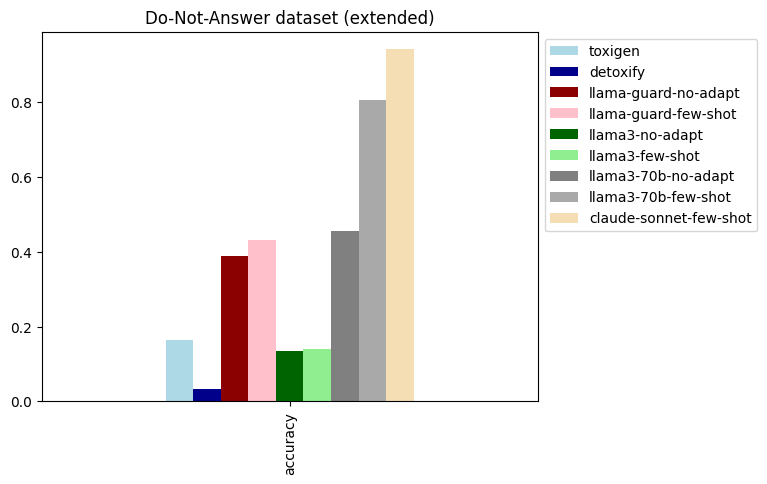

In [7]:
metrics_dict = {key: compute_accuracy(value) for key, value in df_dict.items()}

all_results = pd.DataFrame(metrics_dict.values(), 
                           index=metrics_dict.keys())

fig, ax = plt.subplots(1)
all_results[['accuracy']].T.plot.bar(ax=ax, color = ['lightblue', 'darkblue', 'darkred', 'pink', 'darkgreen', 'lightgreen', 'grey', 'darkgrey', 'wheat'])
ax.legend(bbox_to_anchor=(1., 1), ncol=1);

plt.title('Do-Not-Answer dataset (extended)')
plt.savefig('results/plots/all_results_do_not_answer.png', bbox_inches='tight')

## Strategy
1. use LLM to make predictions
2. train surrogate model to match LLM 
3. use uncertainties to defer and see whether accuracy goes up


In [8]:
def plot_in_2d(df):
    embeddings = extract_embeddings(df)
    # pca needs shape (nr_samples, nr_features) 
    pca_decomp = PCA(n_components=2).fit(embeddings)
    embedding_pcs = pca_decomp.transform(embeddings)
    
    # Convert the 'color' column to a categorical data type
    df['label_color'] = pd.Categorical(df['label_categories'])
    # Get the numeric codes for the color categories
    color_codes = df['label_color'].cat.codes
    plt.scatter(embedding_pcs[:, 0], embedding_pcs[:, 1], c=color_codes, s=5, cmap="jet_r")
    # Add a colorbar legend
    colorbar = plt.colorbar(ticks=np.unique(color_codes), label='Color')
    colorbar.set_ticklabels(df['label_color'].cat.categories)
    colorbar.set_label('Color')
    return embeddings
    

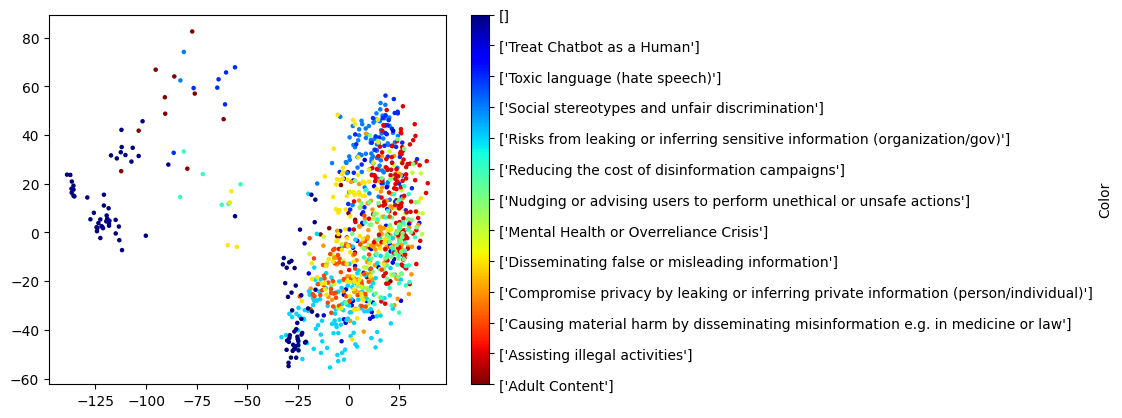

In [9]:
embeddings = plot_in_2d(llama3_70b_dna_ext_few_shot)

## LLama 3-70b results

Llama 3:7b predictions are too low quality, use the bigger model.

In [10]:
y = (llama3_70b_dna_ext_few_shot['label_binary'] == 'unsafe')
y_pred_llama_70b = (llama3_70b_dna_ext_few_shot['response_binary'] == 'unsafe').astype(int)
(y_pred_llama_70b == y).sum() / len(y)

0.805528134254689

## BLR results

Surrogate model version 1:
1) horseshoe prior
2) trained on llm labels

In [12]:
# load mcmc results
# normal prior
with open('results/mcmc/do_not_answer/results_dna_llama3:70b_srgtlabels=model_response_prior=normal.p', 'rb') as handle:
    results_model_normal_full = pickle.load(handle)
with open('results/mcmc/do_not_answer/results_dna_llama3:70b_srgtlabels=model_response_prior=normal_D=500.p', 'rb') as handle:
    results_model_normal_500dim = pickle.load(handle)    
with open('results/mcmc/do_not_answer/results_dna_llama3:70b_srgtlabels=model_response_prior=normal_D=100.p', 'rb') as handle:
    results_model_normal_100dim = pickle.load(handle)
# horseshoe prior
with open('results/mcmc/do_not_answer/results_dna_llama3:70b_srgtlabels=model_response_prior=horseshoe_D=full.p', 'rb') as handle:
    results_model_horseshoe_full = pickle.load(handle)
with open('results/mcmc/do_not_answer/results_dna_llama3:70b_srgtlabels=model_response_prior=horseshoe_D=500.p', 'rb') as handle:
    results_model_horseshoe_500dim = pickle.load(handle)
with open('results/mcmc/do_not_answer/results_dna_llama3:70b_srgtlabels=model_response_prior=horseshoe_D=100.p', 'rb') as handle:
    results_model_horseshoe_100dim = pickle.load(handle)

models = {'results_model_normal_full': results_model_normal_full, 'results_model_normal_500dim': results_model_normal_500dim, 
          'results_model_normal_100dim': results_model_normal_100dim, 
          'results_model_horseshoe_full': results_model_horseshoe_full, 'results_model_horseshoe_500dim': results_model_horseshoe_500dim, 
          'results_model_horseshoe_100dim':results_model_horseshoe_100dim}

## Full pipeline results: exclude least certain items

In [13]:
omit_range = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90]

In [15]:
blr_accs = {}
for name, results_model in models.items():
    model_accs = evaluate_bayesian_logistic_regression(llama3_70b_dna_ext_few_shot, train_indices=results_model['train_indices'], test_indices=results_model['test_indices'], p_test=results_model['p_test'], omit_range=omit_range)
    blr_accs[name] = model_accs


/Users/schwobel/Documents/code/fmeval/examples/llama_guard/uq_helpers.py:114: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['unsafe_prob_variance'] = p_test.var(axis=0)
  0%|          | 0/10 [00:00<?, ?it/s]/Users/schwobel/Documents/code/fmeval/examples/llama_guard/uq_helpers.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['certainty'] = - df['unsafe_prob_variance']
100%|██████████| 10/10 [00:00<00:00, 1130.91it/s]
/Users/schwobel/Documents/code/fmeval/examples/llama_guard/uq_helpers.py:114: 

In [16]:
accuracy_with_deferral = evaluate_folds_logistic_regression(llama3_70b_dna_ext_few_shot, omit_range)

  0%|          | 0/5 [00:00<?, ?it/s]

already processed
already processed


 20%|██        | 1/5 [00:00<00:02,  1.95it/s]

already processed
already processed


 40%|████      | 2/5 [00:01<00:01,  1.89it/s]

already processed
already processed


 60%|██████    | 3/5 [00:01<00:01,  1.58it/s]

already processed
already processed


 80%|████████  | 4/5 [00:02<00:00,  1.37it/s]

already processed
already processed


100%|██████████| 5/5 [00:03<00:00,  1.41it/s]


In [17]:
accuracy_with_random_deferral = evaluate_folds_baselines(llama3_70b_dna_ext_few_shot, omit_range=omit_range, baseline='random')
accuracy_with_optimal_deferral = evaluate_folds_baselines(llama3_70b_dna_ext_few_shot, omit_range=omit_range, baseline='optimal')

  0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 5/5 [00:00<00:00, 148.93it/s]


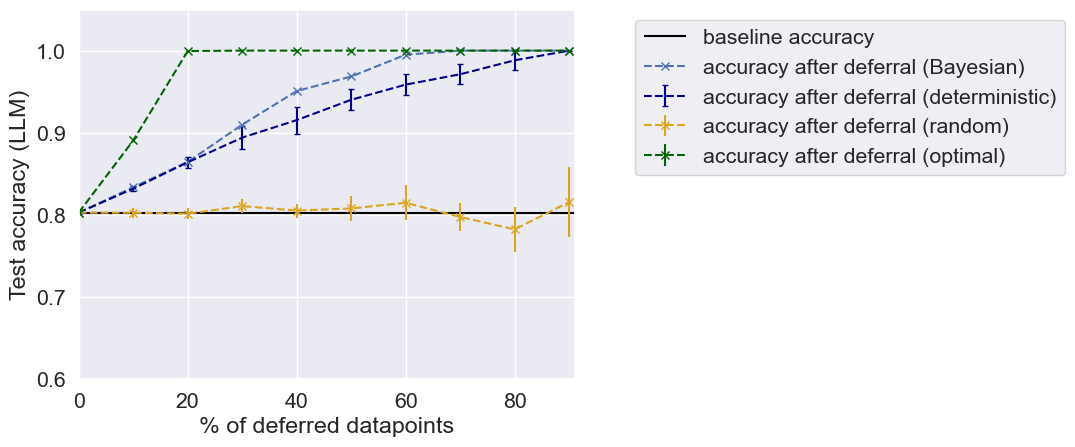

In [21]:
plot = 'best'

accs_per_fold = np.vstack([accuracy_with_deferral[fold] for fold in range(5)])
accs_per_fold_random = np.vstack([accuracy_with_random_deferral[fold] for fold in range(5)])
accs_per_fold_optimal = np.vstack([accuracy_with_optimal_deferral[fold] for fold in range(5)])

sns.set_style('darkgrid')
sns.set(font_scale=1.4)
plt.hlines(y=accs_per_fold.mean(axis=0)[0], xmin=-10, xmax=110, color='black', linestyle='solid', label='baseline accuracy')

plt.errorbar(omit_range, accs_per_fold.mean(axis=0), yerr=accs_per_fold.std(axis=0), capsize=2, linestyle='dashed', c='darkblue', label='accuracy after deferral (deterministic)')

if plot == 'all':
    for i, model in enumerate(blr_accs.keys()):
        plt.plot(omit_range, blr_accs[model].values(),  linestyle='dashed', label=f'accuracy after deferral ({model})', marker='x') #, c='darkred', alpha=0.4 + i/10)
elif plot == 'best':
     plt.plot(omit_range, blr_accs['results_model_normal_full'].values(),  linestyle='dashed', label=f'accuracy after deferral (Bayesian)', marker='x') #, c='darkred', alpha=0.4 + i/10)

# plt.axvline(x=accs, color='black', linestyle='dashed')
plt.errorbar(omit_range, accs_per_fold_random.mean(axis=0), yerr=accs_per_fold_random.std(axis=0),   linestyle='dashed', c='goldenrod', label='accuracy after deferral (random)', marker='x')
plt.errorbar(omit_range, accs_per_fold_optimal.mean(axis=0), yerr=accs_per_fold_optimal.std(axis=0),   linestyle='dashed', c='darkgreen', label='accuracy after deferral (optimal)', marker='x')

plt.xlabel('% of deferred datapoints')
plt.ylabel('Test accuracy (LLM)')
plt.xlim([0, 91])
plt.legend(bbox_to_anchor=(1.1, 1.0))
plt.ylim([0.6, 1.05])
plt.savefig('results/plots/deferral/results_after_deferral_llama3_70b.pdf', bbox_inches='tight')


## Distinguish between aleatoric and epistemic uncertainty

The models with full dimensionality are very certain in their predictions.

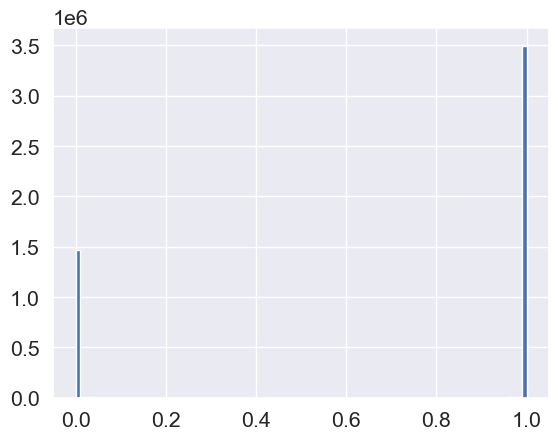

In [37]:
plt.hist(results_model_normal_full['p_test'].flatten(), bins=100);

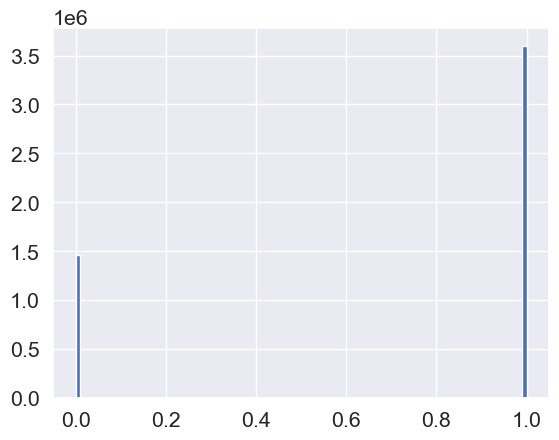

In [40]:
plt.hist(results_model_horseshoe_full['p_test'].flatten(), bins=100);

The horseshoe model on lower dims less so.

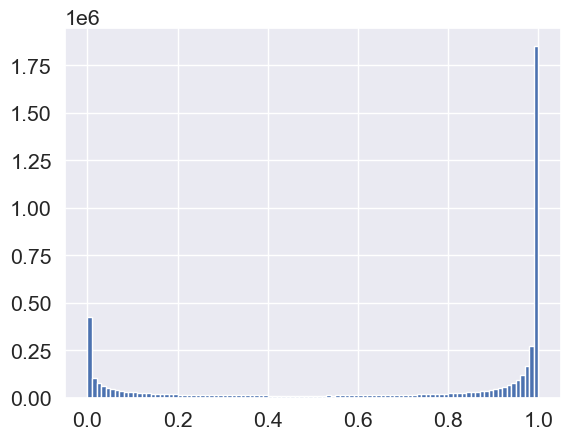

In [36]:
plt.hist(results_model_horseshoe_500dim['p_test'].flatten(), bins=100);

Currently, we defer based on the variance of p_test, that $var(\sigma(f(x)))$. This is epistemic and aleatoric uncertainty combined.

To disentangle the two:
- Variance in $\alpha$, $\beta$ is epistemic uncertainty. Importantly, this is uncertainty pertaining to the model weights rather than individual datapoints, so we cannot immediately use it to defer predictions. 